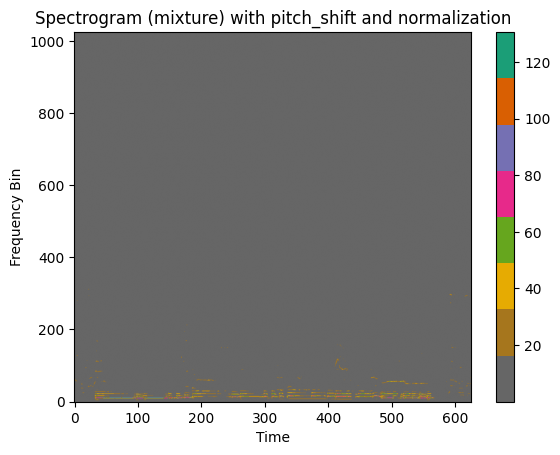

In [ ]:
from torch.utils.data import DataLoader
import torch
import random
from typing import Dict

# Import missing modules for optimization
import torch.optim as optim
from torch.optim import lr_scheduler

# Import our custom dataset and augmentation pipeline.
from process_sml import (
    AudioDatasetFolder, Compose,ComputeSpectrogram,
    RandomPitchShift_wav,RandomVolume_wav,RandomAbsoluteNoise_wav,RandomSpeed_wav,RandomFade_wav,RandomFrequencyMasking_spec,RandomTimeMasking_spec,RandomTimeStretch_spec,
    compute_waveform,reconstruct_waveform_from_complex_spec)
# Import the UNet model and the training function from the training module.
from train_sml import UNet, train_model_source_separation,LiteResUNet
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the component map for the dataset.
COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]
label_names = ["drums", "bass", "other_accompaniment", "vocals"]


argS = Compose([

    #spec transformation 
    RandomTimeStretch_spec(),
    #this two working properly together
    RandomFrequencyMasking_spec(),
    RandomTimeMasking_spec(),

])
argW = Compose(
 [
    # RandomPitchShift_wav(),
    RandomVolume_wav(),
    # RandomSpeed_wav(),
    RandomAbsoluteNoise_wav(),
    RandomFade_wav(),
 ]   
)


# Set random seeds for reproducibility.
torch.manual_seed(42)
random.seed(42)

# Choose device early.
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataset.
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=16000,
    duration=5.0,
    spec_transform=argS,  # list of transforms
    wav_transform=argW,
    is_track_id=True,
    input_name= "mixture"
)

loader_multi = DataLoader(dataset_multi, batch_size=1, shuffle=False)
sample_multi = next(iter(loader_multi))


# Plot spectrogram for the 'mixture' component.
spec_multi = sample_multi['mixture'][0, 0]  # select first sample and first channel
plt.imshow(spec_multi.detach().numpy(), origin='lower', aspect='auto', cmap='Dark2_r')
plt.title("Spectrogram (mixture) with pitch_shift and normalization")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()


In [2]:
x = compute_waveform(spec_multi)

In [3]:
import torchaudio

# Ensure waveform is a FloatTensor in [-1,1]
waveform_tensor = x.detach().cpu().unsqueeze(0)  # shape (1, num_samples) for mono

# Write out
torchaudio.save("reconstructed_without_transformed.wav", waveform_tensor, 16000)

print("Wrote WAV to reconstructed.wav — now open it with your favorite audio player!")


Wrote WAV to reconstructed.wav — now open it with your favorite audio player!


Loaded sample with track_id: ['19316957-7db5-435d-b0e5-3c99332ee329']


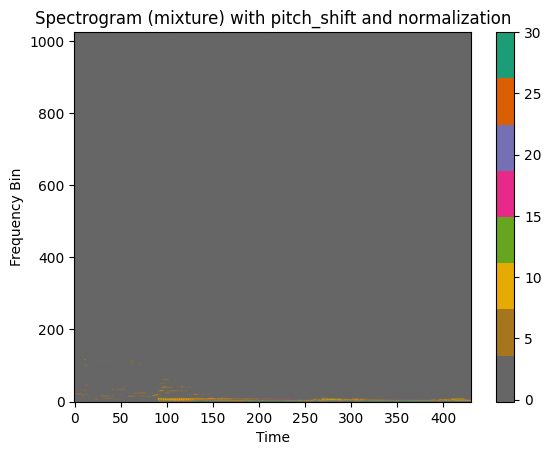

In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from process_musdb18 import AudioDatasetFolder, pitch_shift
import torch

# Define an additional simple normalization transform:
def normalize_spec(spec: torch.Tensor) -> torch.Tensor:
    return (spec - spec.mean()) / (spec.std() + 1e-6)

COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]

IS_TRACK_ID = True
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=44100,
    duration=5.0,
    transform=[pitch_shift, normalize_spec],  # list of transforms
    is_track_id=IS_TRACK_ID,
)

loader_multi = DataLoader(dataset_multi, batch_size=1, shuffle=False)
sample_multi = next(iter(loader_multi))

if IS_TRACK_ID:
    print("Loaded sample with track_id:", sample_multi['track_id'])

# Plot spectrogram for the 'mixture' component.
spec_multi = sample_multi['mixture'][0, 0]  # select first sample and first channel
plt.imshow(spec_multi.detach().numpy(), origin='lower', aspect='auto', cmap='Dark2_r')
plt.title("Spectrogram (mixture) with pitch_shift and normalization")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()
